# 노드 실습


## 환경세팅

이번 노드에서는 augmentation을 텐서플로우 모델 학습에 어떻게 적용할 수 있는지 공부하겠습니다. 지금까지 모델을 훈련시키기 전, 데이터를 전처리해 입력값으로 사용해 오셨을 것입니다. Augmentation도 이처럼 입력 이미지의 데이터를 변경해 주는 과정이므로 일반적인 이미지 데이터 전처리 방법과 활용방법이 동일합니다. 먼저 필요한 라이브러리들을 불러와 줍니다.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('=3')

2024-07-03 04:45:55.925716: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 04:45:55.948448: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 04:45:55.948494: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-03 04:45:55.962741: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


=3


In [2]:
tf.config.list_physical_devices('GPU')

2024-07-03 04:45:58.652306: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-03 04:45:58.652749: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-03 04:45:58.660293: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

- 의도한 건 아니지만 2대의 GPU를 빌려버렸다.

그리고 사용할 데이터셋을 불러옵니다. 이번 시간에는 stanford_dogs 데이터셋을 사용해보도록 합시다. stanford_dogs 데이터셋에는 120개 견종의 이미지가 포함되어 있습니다. 총 20,580장의 이미지에서 12,000장은 학습셋, 나머지 8,580장은 평가용 데이터셋입니다.

데이터를 처음 사용한다면 다운로드해야 하기 때문에 시간이 오래(10분 이상) 걸릴 수 있습니다. 당황하지 마시고 잠시 휴식 시간을 가져 보세요. 데이터셋은 다른 프로젝트에서도 사용할 수 있으니 프로젝트 디렉토리가 아닌 TensorFlow Datasets 기본 디렉토리에 저장합시다.

## 데이터 불러오기

In [3]:
!pip install scipy

In [4]:
%%time
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('=3')

=3
CPU times: user 158 ms, sys: 349 ms, total: 506 ms
Wall time: 497 ms


2024-07-03 04:46:00.523238: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-03 04:46:00.523622: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-03 04:46:00.523960: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

다운로드한 데이터를 확인해볼까요?

2024-07-03 04:46:01.308865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


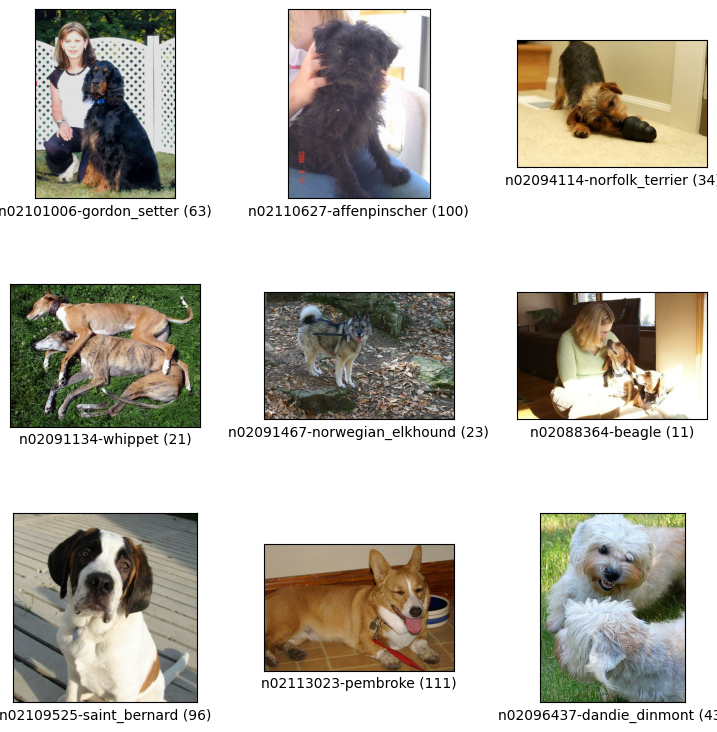

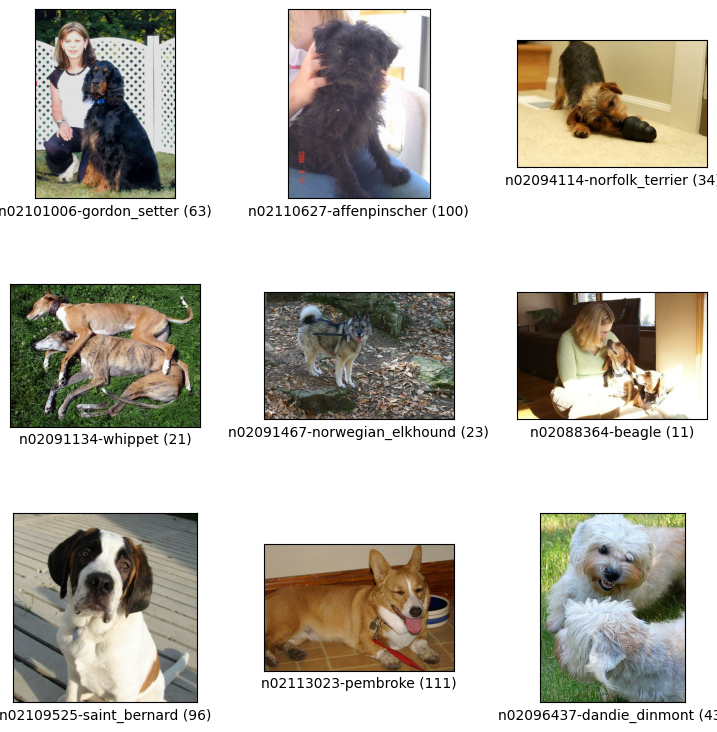

In [5]:
tfds.show_examples(ds_train, ds_info)

In [6]:
ds_info.features['label']

ClassLabel(shape=(), dtype=int64, num_classes=120)

## Augmentation 적용하기

### 텐서플로우 Random Augmentation API 사용하기

많은 augmentation 기법들이 있지만 그중에서 텐서플로우 API로 바로 사용할 수 있는 방법들을 먼저 적용해 보겠습니다. 먼저 이미지셋에 대해서 랜덤한 확률로 바로 적용할 수 있는 augmentation 함수들은 아래와 같습니다.

- random_brightness()
- random_contrast()
- random_crop()
- random_flip_left_right()
- random_flip_up_down()
- random_hue()
- random_jpeg_quality()
- random_saturation()

그럼 Augmentation을 적용하기에 앞서 기본적인 전처리 함수를 만들어 줍시다.

In [7]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

이미지를 변환하는 전처리 함수는 대략 다음과 같은 형태를 가지게 됩니다.

```python
def 전처리_함수(image, label):   # 변환할 이미지와 라벨
    # 이미지 변환 로직 적용
    new_image = 이미지_변환(image)
    return new_image, label
```

이렇게 되면 이미지 변환의 결과로 리턴 받은 이미지를 그다음 전처리 함수의 입력으로 연거푸 재사용할 수 있는 구조가 되어 편리합니다. 위에서 만든 기본적인 전처리 함수도 위와 같은 구조를 가지고 있습니다. 이 함수는 입력받은 이미지를 0~1 사이의 float32로 normalize하고, (224, 224) 사이즈로 resize합니다. 이 함수는 훈련용과 테스트용으로 사용될 모든 이미지에 적용될 것입니다.

맨 위에서 언급한 random augmentation들 중에서 random_flip_left_right()과 random_brightness()를 활용해 보겠습니다. "flip"의 경우 좌우 대칭을 해줍니다. 예컨대 이미지 분류 문제에서 개 이미지는 좌우를 대칭하더라도 문제가 생기지 않습니다. 따라서 좌우대칭의 적용을 통해 데이터를 늘릴 수 있도록 합니다. 여기서 상하 대칭은 테스트 데이터셋의 이미지를 생각해 볼 때 위아래가 뒤집힌 사진이 없으므로 도움이 되지 않을 것이라 적용하지 않습니다. 또 "brightness"를 조절하여 다양한 환경에서 얻어진 이미지에 대응할 수 있도록 하겠습니다.

In [9]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

오늘의 Augmentation을 통해 원본 데이터셋에 다양한 형태의 가공한 형태의 새로운 데이터셋을 얻게 되는 모든 과정을 구현한 메인 함수를 apply_normalize_on_dataset()로 정의하겠습니다.
여기서는 apply_normalize_on_dataset()를 통해서 일반적인 전처리 과정, 즉 normalize, resize, augmentation과 shuffle을 적용하도록 하겠습니다. 이때 주의해야 할 점은 shuffle이나 augmentation은 테스트 데이터셋에는 적용하지 않아야 한다는 점입니다.

여러 결과를 조합하기 위한 앙상블(ensemble) 방법 중 하나로 테스트 데이터셋에 augmentation을 적용하는 test-time augmentation이라는 방법이 있습니다. 이는 캐글 등의 경쟁 머신러닝에 많이 사용되지만, 지금은 개념만 알아두어도 됩니다. 아래 링크에서 test-time augmentation에 관한 설명을 참고하세요.

TTA(test time augmentation) with 케라스

코드에서는 이후에 수행할 비교실험을 위해서 with_aug 매개변수를 통해 augmentation의 적용여부를 결정할 수 있도록 하겠습니다.

tf.data.Datasets.map()

In [10]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


### Random Augmentation 직접 구현하기
위에서는 미리 구현된 random augmentation을 적용하도록 augment() 함수를 작성했습니다. 이번에는 tf.image의 다양한 함수들을 이용해서 직접 다양한 augmentation 기법을 랜덤하게 적용하는 augment2() 함수를 작성해보세요.






## 비교실험하기

이제 비교 실험을 해보도록 하겠습니다. 우리가 비교해야 하는 것은 augmentation을 적용한 데이터를 학습시킨 모델과 적용하지 않은 데이터를 학습시킨 모델의 성능입니다. 새로운 augmentation이 떠오르셨다면 새로운 함수로 augmentation한 데이터와 아닌 데이터를 학습시켜서 어떤 효과가 있는지 실험을 통해 알아볼 수도 있습니다.

아래 코드는 텐서플로우 케라스의 ResNet50 중 imagenet으로 훈련된 모델을 불러옵니다. include_top은 마지막 fully connected layer를 포함할지 여부입니다. 해당 레이어를 포함하지 않고 생성하면 특성 추출기(feature extractor) 부분만 불러와 우리의 필요에 맞게 수정된 fully connected layer를 붙여서 활용할 수 있습니다. 이렇게 하는 이유는 이미지넷(ImageNet)과 우리의 테스트셋이 서로 다른 클래스를 가지므로, 마지막에 추가해야 하는 fully connected layer의 구조(뉴런의 개수) 또한 다르기 때문입니다.

In [11]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


Augmentation을 적용한 데이터셋으로 학습시킬 ResNet을 하나 더 만들어줍니다.

In [12]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


텐서플로우 데이터셋에서 불러온 데이터에 하나는 apply_normalize_on_dataset()에서 with_aug를 False로 주어 augmentation이 적용되지 않도록 하고, 다른 하나는 True로 주어 augmentation이 적용되도록 합니다.






In [13]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [14]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print('=3')

=3


이제 두 개 모델에 각각 augmentation이 적용된 데이터셋과 적용되지 않은 데이터셋을 학습시키고, 검증을 진행합니다.
>아래 학습은 EPOCH=20으로 진행시 GPU 기반으로 3~4시간 가량의 시간이 소요됩니다. Augmentation 적용 효과를 명확히 검증하기 위해서는 최소 이정도의 학습이 진행되어야 하지만, 원활한 학습 진행을 위해서 EPOCH=3 정도로 진행해 보기를 권합니다. 하지만 실제 프로젝트 단계에서는 꼭 충분한 학습이 진행되어야 합니다.


In [15]:
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


Number of devices: 2


In [16]:
num_classes = ds_info.features["label"].num_classes

# Open a strategy scope.
with strategy.scope():
  # Everything that creates variables should be under the strategy scope.
  # In general this is only model construction & `compile()`.

  resnet50 = keras.models.Sequential([
      keras.applications.resnet.ResNet50(
          include_top=False,
          weights='imagenet',
          input_shape=(224,224,3),
          pooling='avg',
    ),
      keras.layers.Dense(num_classes, activation='softmax')
  ])

  aug_resnet50 = keras.models.Sequential([
      keras.applications.resnet.ResNet50(
          include_top=False,
          weights='imagenet',
          input_shape=(224,224,3),
          pooling='avg',
      ),
      keras.layers.Dense(num_classes, activation='softmax')
  ])
  
  resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
  )
  
  aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
  ) 


In [17]:
tf.__version__

'2.16.2'

In [18]:
%%time
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
# EPOCH = 3

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    # use_multiprocessing=True,
)

Epoch 1/20


2024-07-03 04:46:31.628146: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:553] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2024-07-03 04:47:07.709552: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
2024-07-03 04:47:07.730660: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.1881 - loss: 3.6445

2024-07-03 04:48:03.501494: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:553] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


750/750 ━━━━━━━━━━━━━━━━━━━━ 104s 88ms/step - accuracy: 0.1882 - loss: 3.6434 - val_accuracy: 0.1642 - val_loss: 3.7074
Epoch 2/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 54s 73ms/step - accuracy: 0.3906 - loss: 1.9771

2024-07-03 04:48:16.042865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 04:48:16.043016: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5672 - loss: 1.5483

2024-07-03 04:49:09.429869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 04:49:09.430006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


750/750 ━━━━━━━━━━━━━━━━━━━━ 54s 72ms/step - accuracy: 0.5673 - loss: 1.5480 - val_accuracy: 0.7500 - val_loss: 0.4915
Epoch 3/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 1:08 92ms/step - accuracy: 0.8125 - loss: 0.8084

2024-07-03 04:49:09.684252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_60336}}{{node cond/IteratorGetNext}}]]
2024-07-03 04:49:09.684331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_60336}}{{node cond/IteratorGetNext}}]]
	 [[cond/then/_0/cond/OptionalHasValue_1/_33]]
2024-07-03 04:49:09.684406: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12210037271159992680
2024-07-03 04:49:09.684429: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2839000979698029070
2024-07-03 04:49:09.684446: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18304392570278960985
2024-07-03 04:49:09.684463: I tensorflow/core/framework/lo

750/750 ━━━━━━━━━━━━━━━━━━━━ 63s 83ms/step - accuracy: 0.7556 - loss: 0.9057 - val_accuracy: 0.5161 - val_loss: 1.8689
Epoch 4/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 57s 78ms/step - accuracy: 0.8438 - loss: 0.7073

2024-07-03 04:50:12.298471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 04:50:12.298579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


750/750 ━━━━━━━━━━━━━━━━━━━━ 54s 72ms/step - accuracy: 0.8140 - loss: 0.7023 - val_accuracy: 1.0000 - val_loss: 0.0902
Epoch 5/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 49s 66ms/step - accuracy: 0.6562 - loss: 1.1771

2024-07-03 04:51:05.996999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 04:51:05.997165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-03 04:51:06.012085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_60336}}{{node cond/IteratorGetNext}}]]
2024-07-03 04:51:06.012163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_60336}}{{node cond/IteratorGetNext}}]]
	 [[cond/then/_0/cond/OptionalHasValue_1/_33]]
2024-07-03 04:51:06.012202: I tensorflow/core/framework/local_rendezvous.cc:422] L

750/750 ━━━━━━━━━━━━━━━━━━━━ 63s 84ms/step - accuracy: 0.8658 - loss: 0.4998 - val_accuracy: 0.5478 - val_loss: 1.8971
Epoch 6/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 55s 74ms/step - accuracy: 1.0000 - loss: 0.0974

2024-07-03 04:52:08.904871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 04:52:08.905007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


750/750 ━━━━━━━━━━━━━━━━━━━━ 54s 71ms/step - accuracy: 0.9653 - loss: 0.1696 - val_accuracy: 0.7500 - val_loss: 1.1709
Epoch 7/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 43s 59ms/step - accuracy: 0.9531 - loss: 0.1526

2024-07-03 04:53:02.504051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 04:53:02.504190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-03 04:53:02.519565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_60336}}{{node cond/IteratorGetNext}}]]
2024-07-03 04:53:02.519636: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12210037271159992680
2024-07-03 04:53:02.519653: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18304392570278960985
2024-07-03 04:53:02.519669: I tensorflow/core/framew

750/750 ━━━━━━━━━━━━━━━━━━━━ 63s 83ms/step - accuracy: 0.9938 - loss: 0.0513 - val_accuracy: 0.6257 - val_loss: 1.3795
Epoch 8/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 46s 62ms/step - accuracy: 1.0000 - loss: 0.0970

2024-07-03 04:54:05.119158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 04:54:05.119301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


750/750 ━━━━━━━━━━━━━━━━━━━━ 54s 72ms/step - accuracy: 0.9389 - loss: 0.2543 - val_accuracy: 0.7500 - val_loss: 1.2292
Epoch 9/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 52s 70ms/step - accuracy: 0.9844 - loss: 0.1645

2024-07-03 04:54:58.881830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 04:54:58.881956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-03 04:54:58.895253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_60336}}{{node cond/IteratorGetNext}}]]
2024-07-03 04:54:58.895287: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12210037271159992680
2024-07-03 04:54:58.895302: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18304392570278960985
2024-07-03 04:54:58.895320: I tensorflow/core/framew

750/750 ━━━━━━━━━━━━━━━━━━━━ 63s 83ms/step - accuracy: 0.9757 - loss: 0.1251 - val_accuracy: 0.6651 - val_loss: 1.3189
Epoch 10/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 50s 67ms/step - accuracy: 0.9844 - loss: 0.0548

2024-07-03 04:56:01.451796: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 04:56:01.451922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


750/750 ━━━━━━━━━━━━━━━━━━━━ 54s 72ms/step - accuracy: 0.9544 - loss: 0.1884 - val_accuracy: 0.7500 - val_loss: 0.4571
Epoch 11/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 1:00 81ms/step - accuracy: 1.0000 - loss: 0.0627

2024-07-03 04:56:55.342133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 04:56:55.342243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-03 04:56:55.355837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_60336}}{{node cond/IteratorGetNext}}]]
2024-07-03 04:56:55.355884: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12210037271159992680
2024-07-03 04:56:55.355904: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18304392570278960985
2024-07-03 04:56:55.355923: W tensorflow/core/framew

750/750 ━━━━━━━━━━━━━━━━━━━━ 63s 84ms/step - accuracy: 0.9782 - loss: 0.1105 - val_accuracy: 0.6873 - val_loss: 1.2123
Epoch 12/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 56s 75ms/step - accuracy: 1.0000 - loss: 0.0703

2024-07-03 04:57:58.530978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 04:57:58.531151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


750/750 ━━━━━━━━━━━━━━━━━━━━ 54s 72ms/step - accuracy: 0.9900 - loss: 0.0545 - val_accuracy: 1.0000 - val_loss: 0.0489
Epoch 13/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 53s 72ms/step - accuracy: 1.0000 - loss: 0.0085

2024-07-03 04:58:52.808776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 04:58:52.808889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-03 04:58:52.822691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_60336}}{{node cond/IteratorGetNext}}]]
2024-07-03 04:58:52.822743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_60336}}{{node cond/IteratorGetNext}}]]
	 [[cond/then/_0/cond/OptionalHasValue_1/_34]]
2024-07-03 04:58:52.822818: I tensorflow/core/framework/local_rendezvous.cc:422] L

750/750 ━━━━━━━━━━━━━━━━━━━━ 62s 83ms/step - accuracy: 0.9965 - loss: 0.0244 - val_accuracy: 0.7181 - val_loss: 1.1222
Epoch 14/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 1:09 92ms/step - accuracy: 1.0000 - loss: 0.0116

2024-07-03 04:59:54.952103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 04:59:54.952213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


750/750 ━━━━━━━━━━━━━━━━━━━━ 53s 71ms/step - accuracy: 0.9947 - loss: 0.0303 - val_accuracy: 0.7500 - val_loss: 1.7733
Epoch 15/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 1:00 80ms/step - accuracy: 1.0000 - loss: 0.0151

2024-07-03 05:00:48.037555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 05:00:48.037700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-03 05:00:48.051784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_60336}}{{node cond/IteratorGetNext}}]]
2024-07-03 05:00:48.051842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_60336}}{{node cond/IteratorGetNext}}]]
	 [[cond/then/_0/cond/OptionalHasValue_1/_33]]
2024-07-03 05:00:48.051907: I tensorflow/core/framework/local_rendezvous.cc:422] L

750/750 ━━━━━━━━━━━━━━━━━━━━ 63s 83ms/step - accuracy: 0.9980 - loss: 0.0174 - val_accuracy: 0.7292 - val_loss: 1.1143
Epoch 16/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 46s 62ms/step - accuracy: 1.0000 - loss: 0.0048

2024-07-03 05:01:50.641363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 05:01:50.641497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


750/750 ━━━━━━━━━━━━━━━━━━━━ 54s 72ms/step - accuracy: 0.9999 - loss: 0.0061 - val_accuracy: 1.0000 - val_loss: 0.3090
Epoch 17/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 49s 67ms/step - accuracy: 1.0000 - loss: 0.0061

2024-07-03 05:02:44.566002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 05:02:44.566122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-03 05:02:44.579103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_60336}}{{node cond/IteratorGetNext}}]]
2024-07-03 05:02:44.579179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_60336}}{{node cond/IteratorGetNext}}]]
	 [[cond/then/_0/cond/OptionalHasValue_1/_34]]
2024-07-03 05:02:44.579254: I tensorflow/core/framework/local_rendezvous.cc:422] L

750/750 ━━━━━━━━━━━━━━━━━━━━ 62s 83ms/step - accuracy: 0.9998 - loss: 0.0040 - val_accuracy: 0.7099 - val_loss: 1.2240
Epoch 18/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 56s 75ms/step - accuracy: 1.0000 - loss: 0.0029

2024-07-03 05:03:46.764675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 05:03:46.764798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


750/750 ━━━━━━━━━━━━━━━━━━━━ 54s 71ms/step - accuracy: 0.9953 - loss: 0.0277 - val_accuracy: 1.0000 - val_loss: 0.0985
Epoch 19/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 49s 66ms/step - accuracy: 1.0000 - loss: 0.0328

2024-07-03 05:04:40.338644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 05:04:40.338775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-03 05:04:40.352365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_60336}}{{node cond/IteratorGetNext}}]]
2024-07-03 05:04:40.352436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_60336}}{{node cond/IteratorGetNext}}]]
	 [[cond/then/_0/cond/OptionalHasValue_1/_33]]
2024-07-03 05:04:40.352504: I tensorflow/core/framework/local_rendezvous.cc:422] L

750/750 ━━━━━━━━━━━━━━━━━━━━ 63s 84ms/step - accuracy: 0.9978 - loss: 0.0162 - val_accuracy: 0.7229 - val_loss: 1.1529
Epoch 20/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 58s 78ms/step - accuracy: 1.0000 - loss: 0.0023

2024-07-03 05:05:43.549631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 05:05:43.549772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


750/750 ━━━━━━━━━━━━━━━━━━━━ 54s 72ms/step - accuracy: 0.9985 - loss: 0.0081 - val_accuracy: 0.7500 - val_loss: 0.3963
CPU times: user 1h 6min 54s, sys: 3min 48s, total: 1h 10min 43s
Wall time: 20min 5s


2024-07-03 05:06:37.523965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 05:06:37.524103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-03 05:06:37.539213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_60336}}{{node cond/IteratorGetNext}}]]
2024-07-03 05:06:37.539286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_60336}}{{node cond/IteratorGetNext}}]]
	 [[cond/then/_0/cond/OptionalHasValue_1/_33]]
2024-07-03 05:06:37.539353: I tensorflow/core/framework/local_rendezvous.cc:422] L

In [19]:
%%time
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    # use_multiprocessing=True,
)

Epoch 1/20


2024-07-03 05:06:37.985805: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:553] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.1824 - loss: 3.6863

2024-07-03 05:08:18.147977: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:553] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


750/750 ━━━━━━━━━━━━━━━━━━━━ 112s 90ms/step - accuracy: 0.1826 - loss: 3.6851 - val_accuracy: 0.1294 - val_loss: 3.9437
Epoch 2/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 56s 76ms/step - accuracy: 0.5312 - loss: 1.7298

2024-07-03 05:08:30.128139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 05:08:30.128265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


750/750 ━━━━━━━━━━━━━━━━━━━━ 54s 72ms/step - accuracy: 0.5131 - loss: 1.7472 - val_accuracy: 0.5000 - val_loss: 2.8952
Epoch 3/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 53s 72ms/step - accuracy: 0.7031 - loss: 1.0829

2024-07-03 05:09:23.874877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 05:09:23.875038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-03 05:09:23.889316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_321845}}{{node cond/IteratorGetNext}}]]
2024-07-03 05:09:23.889371: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12210037271159992680
2024-07-03 05:09:23.889390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_321845}}{{node co

750/750 ━━━━━━━━━━━━━━━━━━━━ 64s 86ms/step - accuracy: 0.7274 - loss: 0.9701 - val_accuracy: 0.6131 - val_loss: 1.4684
Epoch 4/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 50s 68ms/step - accuracy: 0.9062 - loss: 0.4517

2024-07-03 05:10:28.340322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 05:10:28.340449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


750/750 ━━━━━━━━━━━━━━━━━━━━ 54s 72ms/step - accuracy: 0.8741 - loss: 0.4758 - val_accuracy: 1.0000 - val_loss: 0.2336
Epoch 5/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 51s 70ms/step - accuracy: 0.7656 - loss: 0.8683

2024-07-03 05:11:22.627633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 05:11:22.627812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-03 05:11:22.642723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_321845}}{{node cond/IteratorGetNext}}]]
2024-07-03 05:11:22.642800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_321845}}{{node cond/IteratorGetNext_1}}]]
2024-07-03 05:11:22.642902: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key ha

750/750 ━━━━━━━━━━━━━━━━━━━━ 64s 85ms/step - accuracy: 0.7898 - loss: 0.7928 - val_accuracy: 0.5427 - val_loss: 1.8212
Epoch 6/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 51s 69ms/step - accuracy: 0.7656 - loss: 0.9093

2024-07-03 05:12:26.517134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 05:12:26.517256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


750/750 ━━━━━━━━━━━━━━━━━━━━ 54s 72ms/step - accuracy: 0.7934 - loss: 0.7249 - val_accuracy: 0.7500 - val_loss: 0.9644
Epoch 7/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 48s 65ms/step - accuracy: 0.5000 - loss: 2.2569

2024-07-03 05:13:20.476460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 05:13:20.476558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-03 05:13:20.489458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_321845}}{{node cond/IteratorGetNext}}]]
2024-07-03 05:13:20.489514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_321845}}{{node cond/IteratorGetNext_1}}]]
2024-07-03 05:13:20.489578: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key ha

750/750 ━━━━━━━━━━━━━━━━━━━━ 62s 82ms/step - accuracy: 0.7657 - loss: 0.8309 - val_accuracy: 0.5870 - val_loss: 1.6493
Epoch 8/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 57s 77ms/step - accuracy: 0.6719 - loss: 1.0344

2024-07-03 05:14:22.049339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 05:14:22.049461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


750/750 ━━━━━━━━━━━━━━━━━━━━ 54s 72ms/step - accuracy: 0.8869 - loss: 0.4273 - val_accuracy: 1.0000 - val_loss: 0.2920
Epoch 9/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 52s 70ms/step - accuracy: 1.0000 - loss: 0.1161

2024-07-03 05:15:15.840160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 05:15:15.840297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-03 05:15:15.856117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_321845}}{{node cond/IteratorGetNext}}]]
2024-07-03 05:15:15.856165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_321845}}{{node cond/IteratorGetNext}}]]
	 [[cond/then/_0/cond/OptionalHasValue_1/_33]]
2024-07-03 05:15:15.856216: I tensorflow/core/framework/local_rendezvous.cc:422]

750/750 ━━━━━━━━━━━━━━━━━━━━ 62s 83ms/step - accuracy: 0.9446 - loss: 0.2376 - val_accuracy: 0.6168 - val_loss: 1.5609
Epoch 10/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 52s 70ms/step - accuracy: 0.7188 - loss: 0.7478

2024-07-03 05:16:18.238020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 05:16:18.238128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


750/750 ━━━━━━━━━━━━━━━━━━━━ 54s 72ms/step - accuracy: 0.8762 - loss: 0.4298 - val_accuracy: 1.0000 - val_loss: 0.0149
Epoch 11/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 53s 71ms/step - accuracy: 0.7031 - loss: 0.6024

2024-07-03 05:17:12.484140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 05:17:12.484278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-03 05:17:12.499795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_321845}}{{node cond/IteratorGetNext}}]]
2024-07-03 05:17:12.499844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_321845}}{{node cond/IteratorGetNext}}]]
	 [[cond/then/_0/cond/OptionalHasValue_1/_33]]
2024-07-03 05:17:12.499918: I tensorflow/core/framework/local_rendezvous.cc:422]

750/750 ━━━━━━━━━━━━━━━━━━━━ 62s 83ms/step - accuracy: 0.9157 - loss: 0.3070 - val_accuracy: 0.5886 - val_loss: 1.7525
Epoch 12/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 52s 70ms/step - accuracy: 0.8906 - loss: 0.4092

2024-07-03 05:18:14.968244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 05:18:14.968363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


750/750 ━━━━━━━━━━━━━━━━━━━━ 54s 72ms/step - accuracy: 0.9100 - loss: 0.3151 - val_accuracy: 0.7500 - val_loss: 0.6248
Epoch 13/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 52s 71ms/step - accuracy: 0.9844 - loss: 0.2141

2024-07-03 05:19:08.938690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 05:19:08.938842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-03 05:19:08.951228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_321845}}{{node cond/IteratorGetNext}}]]
2024-07-03 05:19:08.951299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_321845}}{{node cond/IteratorGetNext}}]]
	 [[cond/then/_0/cond/OptionalHasValue_1/_33]]
2024-07-03 05:19:08.951359: I tensorflow/core/framework/local_rendezvous.cc:422]

750/750 ━━━━━━━━━━━━━━━━━━━━ 63s 84ms/step - accuracy: 0.9538 - loss: 0.1823 - val_accuracy: 0.6679 - val_loss: 1.3943
Epoch 14/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 54s 73ms/step - accuracy: 1.0000 - loss: 0.0724

2024-07-03 05:20:12.072588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 05:20:12.072713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


750/750 ━━━━━━━━━━━━━━━━━━━━ 58s 78ms/step - accuracy: 0.9750 - loss: 0.1115 - val_accuracy: 1.0000 - val_loss: 0.4063
Epoch 15/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 1:00 80ms/step - accuracy: 1.0000 - loss: 0.0164

2024-07-03 05:21:10.350229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 05:21:10.350363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-03 05:21:10.363090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_321845}}{{node cond/IteratorGetNext}}]]
2024-07-03 05:21:10.363160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_321845}}{{node cond/IteratorGetNext_1}}]]
2024-07-03 05:21:10.363201: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key ha

750/750 ━━━━━━━━━━━━━━━━━━━━ 64s 85ms/step - accuracy: 0.9685 - loss: 0.1292 - val_accuracy: 0.6362 - val_loss: 1.5163
Epoch 16/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 52s 70ms/step - accuracy: 1.0000 - loss: 0.0425

2024-07-03 05:22:14.347325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 05:22:14.347465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


750/750 ━━━━━━━━━━━━━━━━━━━━ 55s 74ms/step - accuracy: 0.9899 - loss: 0.0598 - val_accuracy: 1.0000 - val_loss: 0.0284
Epoch 17/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 56s 75ms/step - accuracy: 0.9844 - loss: 0.0363

2024-07-03 05:23:09.739522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 05:23:09.739643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-03 05:23:09.755723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_321845}}{{node cond/IteratorGetNext}}]]
2024-07-03 05:23:09.755772: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12210037271159992680
2024-07-03 05:23:09.755787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_321845}}{{node co

750/750 ━━━━━━━━━━━━━━━━━━━━ 63s 84ms/step - accuracy: 0.9930 - loss: 0.0393 - val_accuracy: 0.7097 - val_loss: 1.1852
Epoch 18/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 45s 61ms/step - accuracy: 0.9844 - loss: 0.0261

2024-07-03 05:24:12.739318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 05:24:12.739463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


750/750 ━━━━━━━━━━━━━━━━━━━━ 55s 73ms/step - accuracy: 0.9956 - loss: 0.0317 - val_accuracy: 0.7500 - val_loss: 0.5190
Epoch 19/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 55s 75ms/step - accuracy: 0.9844 - loss: 0.0329

2024-07-03 05:25:07.800069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 05:25:07.800228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-03 05:25:07.814914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_321845}}{{node cond/IteratorGetNext}}]]
2024-07-03 05:25:07.815003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_321845}}{{node cond/IteratorGetNext}}]]
	 [[cond/then/_0/cond/OptionalHasValue_1/_33]]
2024-07-03 05:25:07.815084: I tensorflow/core/framework/local_rendezvous.cc:422]

750/750 ━━━━━━━━━━━━━━━━━━━━ 63s 84ms/step - accuracy: 0.9923 - loss: 0.0405 - val_accuracy: 0.7041 - val_loss: 1.2459
Epoch 20/20
  2/750 ━━━━━━━━━━━━━━━━━━━━ 56s 75ms/step - accuracy: 1.0000 - loss: 0.0245

2024-07-03 05:26:11.067661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 05:26:11.067799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


750/750 ━━━━━━━━━━━━━━━━━━━━ 55s 73ms/step - accuracy: 0.9941 - loss: 0.0366 - val_accuracy: 1.0000 - val_loss: 0.3421
CPU times: user 1h 7min 22s, sys: 3min 38s, total: 1h 11min
Wall time: 20min 28s


2024-07-03 05:27:06.063951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-03 05:27:06.064090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-07-03 05:27:06.079012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_321845}}{{node cond/IteratorGetNext}}]]
2024-07-03 05:27:06.079087: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12210037271159992680
2024-07-03 05:27:06.079106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_321845}}{{node co

주요 포인트

	1.	assert_cardinality 경고:
	•	assert_cardinality 변환은 auto-shard 재작성에서 처리되지 않으며 제거될 것이라는 경고입니다. 이는 데이터 파이프라인 최적화 문제와 관련이 있으며, 모델 학습의 성능에 영향을 줄 수 있습니다.
	2.	OUT_OF_RANGE 오류:
	•	이 오류는 데이터셋의 끝에 도달했음을 나타냅니다. 반복적으로 발생하는 이 오류는 데이터셋이 예상보다 빨리 끝나는 경우에 발생할 수 있습니다.
	3.	Local rendezvous recv item cancelled 메시지:
	•	이는 TensorFlow가 분산 학습 시 데이터셋의 끝에 도달했을 때 발생하는 로그 메시지입니다. 데이터셋의 마지막에 도달했음을 나타내며, 이는 전체 학습 프로세스의 종료를 의미합니다.

훈련 과정을 시각화 해봅시다.

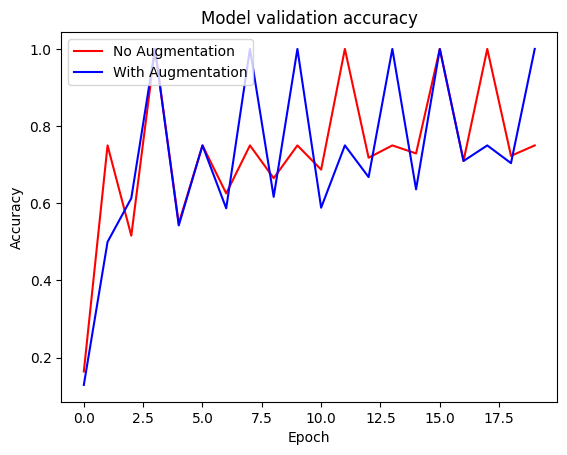

In [20]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

조금 더 확대해 살펴봅시다.

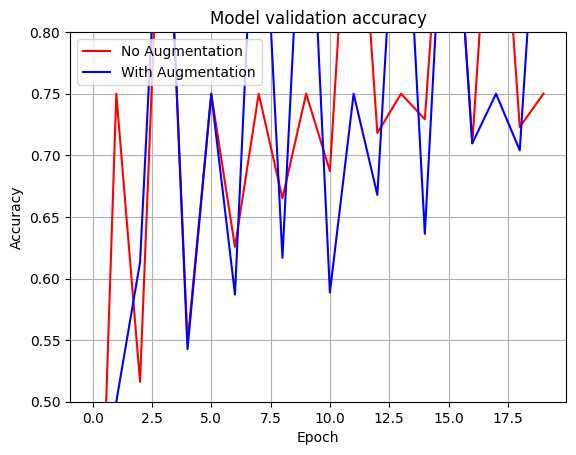

In [21]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

참고로, EPOCH=20으로 수행해 본 두 모델의 훈련 과정 시각화한 내용은 아래 그림과 같습니다. Augmentation 적용한 경우가 보다 천천히 학습되지만, EPOCH 10을 전후해서 aug_resnet50의 accuracy가 더 높게 형성되는 것을 확인할 수 있습니다.

## 심화기법 1) Cutmix Augmentation

지금부터 조금 더 복잡한 augmentation 방법을 알아보겠습니다.

첫 번째는 CutMix augmentation입니다.

CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features
Chris Deotte's CutMix and MixUp on GPU/TPU
CutMix는 네이버 클로바(CLOVA)에서 발표한 CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features 에서 제안된 방법입니다. 이름인 CutMix를 보고 유추할 수 있듯 이미지 데이터를 자르고 섞는다고 생각할 수 있습니다.

아래 표에서 ResNet-50 컬럼은 우리가 일반적으로 사용해왔던 방식을 나타냅니다. Mixup은 특정 비율로 픽셀별 값을 섞는 방식이고, Cutout은 이미지를 잘라내는 방식입니다. CutMix는 Mixup과 비슷하지만 일정 영역을 잘라서 붙여주는 방법입니다. 차에 비유하면 블렌딩 같은 방법이죠.

두 번째 링크인 Chris Deotte's CutMix and MixUp on GPU/TPU에서는 캐글 그랜드마스터인 Chris Deotte가 구현한 CutMix와 MixUp을 확인 할 수 있습니다. 남은 스텝에서 CutMix와 MixUp을 구현하면서 참고하도록 합시다. 참고로 캐글에서 지금 참가하고 있는 대회와 비슷한 태스크의 경진대회가 있는 경우, 다른 사람들이 적용한 방법들을 찾아보는 것도 인사이트를 얻는 데 좋습니다.

CutMix는 이미지를 섞는 부분과 섞은 이미지에 맞추어 라벨을 섞는 부분을 포함합니다. 이제 한 부분씩 구현해 보겠습니다.

### 1) 이미지 섞기
가장 먼저 두 개의 이미지를 섞어주는 것부터 생각해 봅시다. 배치 내의 이미지를 두 개 골라서 섞어줍니다. 이때 이미지에서 잘라서 섞어주는 영역을 바운딩 박스(bounding box)라고 부릅니다.

예시를 위해 훈련데이터셋에서 이미지 2개를 가져와 보겠습니다.

아래 코드 블록에 바운딩 박스의 위치를 랜덤하게 뽑고 이를 잘라내서 두 개의 이미지를 섞어주는 함수를 만들어 보세요! 이미지를 텐서로 만들어 텐서플로우 연산을 사용해 봅시다. 이때 이미지는 tfds에서 한 장을 뽑아서 사용해 보세요.

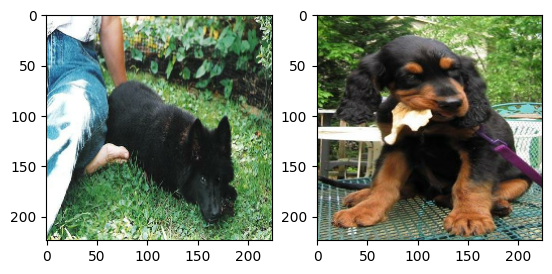

In [22]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

두 개의 이미지를 얻었습니다.

이 중 첫 번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두 번째 이미지 b가 있을 때, a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수를 먼저 구현해 봅시다.

이번 노드에서는 이미지 a, b가 모두 (224, 224)로 resize되어 두 이미지의 width, height가 같은 경우로 가정할 수 있지만, CutMix 공식 repo 에서는 width, height가 다르더라도 가변적으로 적용할 수 있도록 구현되어 있기 때문에, 임의의 이미지 사이즈에 대해서도 유연하게 대응 가능하도록 구현해 보겠습니다.

In [23]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(172, shape=(), dtype=int32)
y :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(219, shape=(), dtype=int32)


바탕이미지 image_a에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 image_b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수를 구현해 봅시다.

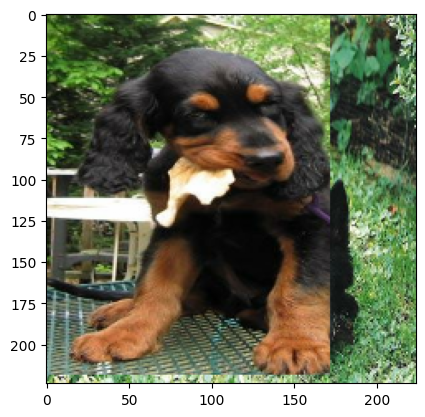

In [24]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

### 2) 라벨 섞기
이미지를 섞었다면 라벨도 이에 맞게 섞어주어야 합니다. 그림에서 볼 수 있듯, 우리가 강아지와 고양이의 이미지를 섞었다면 라벨 또한 적절한 비율로 섞여야 합니다.

CutMix에서는 면적에 비례해서 라벨을 섞어줍니다. 섞인 이미지의 전체 이미지 대비 비율을 계산해서 두 가지 라벨의 비율로 더해줍니다. 예를 들어 A 클래스를 가진 원래 이미지 image_a와 B 클래스를 가진 이미지 image_b를 섞을 때 image_a를 0.4만큼 섞었을 경우, 0.4만큼의 클래스 A, 0.6만큼의 클래스 B를 가지도록 해줍니다. 이때 라벨 벡터는 보통 클래스를 표시하듯 클래스 1개만 1의 값을 가지는 원-핫 인코딩이 아니라 A와 B 클래스에 해당하는 인덱스에 각각 0.4, 0.6을 배분하는 방식을 사용합니다.

위에서 섞인 이미지 두 가지에 대하여 라벨을 만들 때 적절한 비율로 라벨을 합쳐주는 함수를 구현해 봅시다.

In [25]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.75071746, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

이제 거의다 준비되었습니다.
위에서 구현한 두 함수 mix_2_images()와 mix_2_label()을 활용하여 배치 단위의 cutmix() 함수를 구현해 봅시다.

In [26]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


## 심화기법 2) Mixup Augmentation

Mixup은 앞에서 보여드린 CutMix보다 간단하게 이미지와 라벨을 섞어줍니다. 아래 참고자료는 앞에서 본 CutMix 비교표에서 "Mixup"이라는 방법이 제안된 논문입니다. 두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식으로 CutMix보다 구현이 간단하다고 볼 수 있습니다. 아래에서 직접 Mixup 함수를 구현해보세요!

mixup:Beyond Empirical Risk Minimization
두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어주면 됩니다.

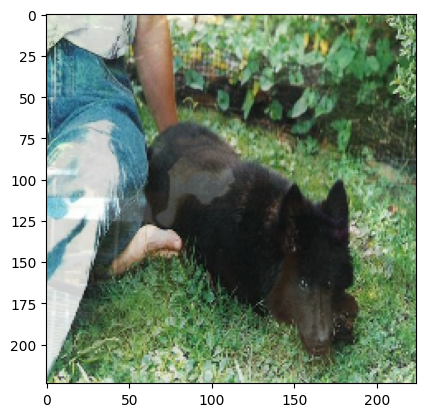

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.1950866 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.8049134 0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.      

In [27]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

그러면 위에서 구현한 함수를 활용하여 배치 단위의 mixup() 함수를 구현해 봅시다.

In [28]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3
